In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx

import qiskit
from qiskit import Aer, IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

from typing import List, Tuple

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='...', group='...', project='...')
backend = provider.get_backend('ibmq_johannesburg')

In [16]:
def swap_before_toffoli(backend, connectivity, qubits, cl, initial_locs: List[qiskit.circuit.QuantumRegister]=None) -> Tuple[qiskit.circuit.QuantumCircuit, List[qiskit.circuit.QuantumRegister]]:
    circuit = qiskit.circuit.QuantumCircuit(qubits, cl)
    
    circuit.x(initial_locs[0])
    circuit.x(initial_locs[1])
    
    min_length = float("inf")
    min_paths = None
    for i in initial_locs:
        paths = []
        for j in initial_locs:
            if i == j:
                continue
            paths.append(nx.shortest_path(connectivity, j, i))
        length = sum([len(path) - 2 for path in paths])
        if min_length > length:
            min_length = length
            min_paths = paths
    qubit_mapping = {}
    for index, q in enumerate(initial_locs):
        qubit_mapping[q] = index
    used_locs = set()
    new_locs = [None] * 3
    for path in min_paths:
        use_qubit = None
        for index, qubit in enumerate(path[:-2]):
            if path[index + 1] in used_locs:
                use_qubit = qubit
                break
            circuit.cx(path[index], path[index + 1])
            circuit.cx(path[index + 1], path[index])
            circuit.cx(path[index], path[index + 1])
        if use_qubit:
            new_locs[qubit_mapping[path[0]]] = use_qubit
            used_locs.add(use_qubit)
        else:
            new_locs[qubit_mapping[path[0]]] = path[-2]
            used_locs.add(path[-2])
    new_locs[qubit_mapping[min_paths[0][-1]]] = min_paths[0][-1]
                     
    assert None not in new_locs
    
    return circuit, new_locs

In [17]:
def create_connectivity(backend, qubits):
    config = backend.configuration()
    coupling_map = config.coupling_map
    graph = nx.Graph()
    for pair in coupling_map:
        graph.add_edge(qubits[pair[0]], qubits[pair[1]])
    return graph

In [18]:
# 8-CNOT Toffoli, aka "Craig"
def add_craig_toffoli(circuit, qubits, connectivity):
    distance_1 = len(nx.shortest_path(connectivity, qubits[0], qubits[1]))
    distance_2 = len(nx.shortest_path(connectivity, qubits[1], qubits[2]))
    
    remapped_qubits = [None] * 3
    if distance_1 == distance_2:
        remapped_qubits = qubits
    elif distance_1 > distance_2:
        remapped_qubits[0] = qubits[0]
        remapped_qubits[1] = qubits[2]
        remapped_qubits[2] = qubits[1]
    elif distance_1 < distance_2:
        remapped_qubits[0] = qubits[2]
        remapped_qubits[1] = qubits[0]
        remapped_qubits[2] = qubits[1]
    
    circuit.h(qubits[2])
    circuit.t(remapped_qubits)
    circuit.ry(-np.pi/2, remapped_qubits[1])
    circuit.ry(-np.pi/2, remapped_qubits[2])
    circuit.cz(remapped_qubits[0], remapped_qubits[1])
    circuit.ry(np.pi/2, remapped_qubits[1])
    circuit.cz(remapped_qubits[1], remapped_qubits[2])
    circuit.tdg(remapped_qubits[1])
    circuit.ry(np.pi/2, remapped_qubits[2])
    circuit.ry(-np.pi/2, remapped_qubits[1])
    circuit.t(remapped_qubits[2])
    circuit.cz(remapped_qubits[0], remapped_qubits[1])
    circuit.ry(-np.pi/2, remapped_qubits[2])
    circuit.ry(np.pi/2, remapped_qubits[1])
    circuit.cz(remapped_qubits[1], remapped_qubits[2])
    circuit.ry(-np.pi/2, remapped_qubits[1])
    circuit.ry(np.pi/2, remapped_qubits[2])
    circuit.cz(remapped_qubits[0], remapped_qubits[1])
    circuit.tdg(remapped_qubits[2])
    circuit.ry(np.pi/2, remapped_qubits[1])
    circuit.ry(-np.pi/2, remapped_qubits[2])
    circuit.cz(remapped_qubits[1], remapped_qubits[2])
    circuit.ry(np.pi/2, remapped_qubits[2])
    circuit.ry(-np.pi/2, remapped_qubits[1])
    circuit.cz(remapped_qubits[0], remapped_qubits[1])
    circuit.tdg(remapped_qubits[2])
    circuit.ry(np.pi/2, remapped_qubits[1])
    circuit.ry(-np.pi/2, remapped_qubits[2])
    circuit.cz(remapped_qubits[1], remapped_qubits[2])
    circuit.ry(np.pi/2, remapped_qubits[2])
    circuit.h(qubits[2])
    
    circuit.barrier()
    circuit.measure(remapped_qubits[0], 0)
    circuit.measure(remapped_qubits[1], 1)
    circuit.measure(remapped_qubits[2], 2)

    return circuit
        
def add_regular_toffoli(circuit, qubits):
    circuit.h(qubits[2])
    circuit.cx(qubits[1], qubits[2])
    circuit.tdg(qubits[2])
    circuit.cx(qubits[0], qubits[2])
    circuit.t(qubits[2])
    circuit.cx(qubits[1], qubits[2])
    circuit.tdg(qubits[2])
    circuit.cx(qubits[0], qubits[2])
    circuit.t(qubits[1])
    circuit.t(qubits[2])
    circuit.cx(qubits[0], qubits[1])
    circuit.t(qubits[0])
    circuit.tdg(qubits[1])
    circuit.cx(qubits[0], qubits[1])
    circuit.h(qubits[2])
    
    circuit.barrier()
    circuit.measure(qubits[0], 0)
    circuit.measure(qubits[1], 1)
    circuit.measure(qubits[2], 2)
    
    return circuit

In [25]:
def create_mapped_circuit(backend, early_swap: bool, toffoli_strat: str, initial_locs):
    num_qubits = backend.configuration().num_qubits
    qr = qiskit.circuit.QuantumRegister(num_qubits)
    cl = qiskit.circuit.ClassicalRegister(num_qubits)
    connectivity = create_connectivity(backend, qr)
    
    if initial_locs == None:
        initial_locs = []
        for i in range(0, 3):
            item = random.randint(0, num_qubits - 1)
            while item in initial_locs:
                item = random.randint(0, num_qubits - 1)
            initial_locs.append(qr[item])
    else:
        new_il = []
        for il in initial_locs:
            new_il.append(qr[int(il)])
        initial_locs = new_il

    if early_swap:
        swap_circuit, qubits_loc = swap_before_toffoli(backend, connectivity, qr, cl, initial_locs)
    else:
        swap_circuit = qiskit.circuit.QuantumCircuit(qr, cl)
        swap_circuit.x(initial_locs[0])
        swap_circuit.x(initial_locs[1])
        qubits_loc = initial_locs
    print(qubits_loc)
    if toffoli_strat == "craig":
        full_circuit = add_craig_toffoli(swap_circuit, qubits_loc, connectivity)
    else:
        full_circuit = add_regular_toffoli(swap_circuit, qubits_loc)
        
    # return full_circuit
    fully_compiled  = qiskit.transpile(
        full_circuit,
        backend=backend,
        basis_gates=['u1', 'u2', 'u3', 'cx'],
        initial_layout=[i for i in range(num_qubits)], 
        # routing_method='lookahead', 
        optimization_level=3,
    )
    
    return fully_compiled

In [28]:
def gen_random_init_mapping(numq, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    which = np.random.choice(range(numq), 3, replace=False)
    return list(which)

In [29]:
class ToffData:
    def __init__(self, backend, seed=None):
        which = gen_random_init_mapping(backend.configuration().num_qubits, seed=seed)
        self.init_locs = which
        self.backend = backend
        
        # The Circuits
        self.true_craig = None
        self.true_norm = None
        self.false_craig = None
        self.false_norm = None
        
        self.generate_circuits()
        
        # Always check the 0, 1, 2 classical bits for correctness
        
        self.jindices = []
        
        self.distance = 0
        
    def generate_circuits(self):
        self.true_craig = create_mapped_circuit(backend, True, 'craig', self.init_locs)
        self.true_norm = create_mapped_circuit(backend, True, 'norm', self.init_locs)
        self.false_craig = create_mapped_circuit(backend, False, 'craig', self.init_locs)
        self.false_norm = create_mapped_circuit(backend, False, 'norm', self.init_locs)
        
    def __lt__(self, other):
        return self.distance < other.distance

In [30]:
# Let's generate 100 of these!
all_toff_data = [ToffData(backend=backend) for i in range(100)]

[Qubit(QuantumRegister(20, 'q198'), 12), Qubit(QuantumRegister(20, 'q198'), 8), Qubit(QuantumRegister(20, 'q198'), 7)]
[Qubit(QuantumRegister(20, 'q199'), 12), Qubit(QuantumRegister(20, 'q199'), 8), Qubit(QuantumRegister(20, 'q199'), 7)]
[Qubit(QuantumRegister(20, 'q200'), 11), Qubit(QuantumRegister(20, 'q200'), 8), Qubit(QuantumRegister(20, 'q200'), 7)]
[Qubit(QuantumRegister(20, 'q201'), 11), Qubit(QuantumRegister(20, 'q201'), 8), Qubit(QuantumRegister(20, 'q201'), 7)]
[Qubit(QuantumRegister(20, 'q202'), 16), Qubit(QuantumRegister(20, 'q202'), 18), Qubit(QuantumRegister(20, 'q202'), 17)]
[Qubit(QuantumRegister(20, 'q203'), 16), Qubit(QuantumRegister(20, 'q203'), 18), Qubit(QuantumRegister(20, 'q203'), 17)]
[Qubit(QuantumRegister(20, 'q204'), 5), Qubit(QuantumRegister(20, 'q204'), 14), Qubit(QuantumRegister(20, 'q204'), 17)]
[Qubit(QuantumRegister(20, 'q205'), 5), Qubit(QuantumRegister(20, 'q205'), 14), Qubit(QuantumRegister(20, 'q205'), 17)]
[Qubit(QuantumRegister(20, 'q206'), 6), Qu

In [36]:
for c in all_toff_data:
    print(get_2q_count(c.true_craig), get_2q_count(c.false_norm))

11 15
23 31
17 22
11 15
29 45
20 36
14 24
23 28
17 16
17 24
17 21
11 22
17 24
14 18
17 24
14 24
14 16
23 39
14 18
17 25
17 27
29 39
11 12
17 18
17 15
17 27
14 21
23 25
17 31
17 24
17 19
17 22
17 27
14 25
29 33
23 33
14 27
17 33
17 24
20 31
17 30
29 25
14 18
11 24
14 27
17 18
17 24
20 33
14 22
26 30
14 16
23 39
14 24
14 16
23 36
23 33
17 24
17 27
8 7
17 19
20 33
32 39
14 21
17 21
14 19
23 31
14 18
20 25
20 27
11 18
26 39
32 46
8 9
20 36
23 33
26 24
11 15
14 24
17 25
17 28
26 36
26 25
11 13
20 33
20 31
8 15
23 28
20 21
29 45
14 18
14 21
29 40
17 30
20 21
26 31
17 24
17 30
8 12
17 30
11 15


In [363]:
print(all_toff_data[9].init_locs)
all_toff_data[9].true_craig.draw(fold=-1)

[3, 13, 8]


░          
  q3827_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                                                                                                                        ░          
  q3827_1 -> 1 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                                                                                                                        ░          
  q3827_2 -> 2 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
               ┌─────────────┐     ┌───┐                                                                                                                                                                                                                                                ░          
  q3827_3 -> 3 ┤ U3(pi,0,pi) ├──■──┤ X ├──■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
               └─────────────┘┌─┴─┐└─┬─┘┌─┴─┐          ┌───┐                                                                                                                                                                                                                            ░          
  q3827_4 -> 4 ───────────────┤ X ├──■──┤ X ├──■───────┤ X ├───────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                              └───┘     └───┘  │       └─┬─┘       │                                                                                                                                                                                                                    ░          
  q3827_5 -> 5 ────────────────────────────────┼─────────┼─────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                               │         │         │                                                                                                                                                                                                                    ░          
  q3827_6 -> 6 ────────────────────────────────┼─────────┼─────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                               │  ┌───┐  │         │  ┌───┐┌────────────────────┐                    ┌───┐     ┌───────────┐                         ┌───┐    ┌────────────┐    

In [31]:
all_circuits = []

i = 0
for data in all_toff_data:
    all_circuits.append(data.true_craig)
    all_circuits.append(data.true_norm)
    all_circuits.append(data.false_craig)
    all_circuits.append(data.false_norm)
    data.jindices = [i, i + 1, i + 2, i + 3]
    i = i + 4

In [340]:
job = qiskit.execute(all_circuits, backend=backend, shots=8192)

In [342]:
job_monitor(job)

Job Status: job has successfully run


In [344]:
results = job.result().get_counts()

In [ ]:
for data in all_toff_data:
    data.counts = []
    for index in data.jindices:
        data.counts.append(results[index])   

In [32]:
def get_2q_count(c):
    count = 0
    for e in c:
        if len(e[1]) == 2:
            count += 1
            
    return count

str(get_2q_count(all_toff_data[0].true_craig))

'11'

In [349]:
with open('raw-johannesburg-counts.data', 'w+') as f:
    for data in all_toff_data:
        for pos in data.init_locs:
            f.write(str(pos))
            f.write(',')
        f.write('\n')
        f.write(str(data.distance))
        f.write('\n')
        f.write('PreSwap,Craig\n')
        f.write(str(get_2q_count(data.true_craig)))
        f.write('\n')
        for key in data.counts[0]:
            f.write(key)
            f.write(',')
            f.write(str(data.counts[0][key]))
            f.write('\n')
            
        f.write('PreSwap,Norm\n')
        f.write(str(get_2q_count(data.true_norm)))
        f.write('\n')
        for key in data.counts[1]:
            f.write(key)
            f.write(',')
            f.write(str(data.counts[1][key]))
            f.write('\n')
            
        f.write('Qiskit,Craig\n')
        f.write(str(get_2q_count(data.false_craig)))
        f.write('\n')
        for key in data.counts[2]:
            f.write(key)
            f.write(',')
            f.write(str(data.counts[2][key]))
            f.write('\n')
            
        f.write('Qiskit,Norm\n')
        f.write(str(get_2q_count(data.false_norm)))
        f.write('\n')
        for key in data.counts[3]:
            f.write(key)
            f.write(',')
            f.write(str(data.counts[3][key]))
            f.write('\n')

In [350]:
qr = qiskit.circuit.QuantumRegister(backend.configuration().num_qubits)

connectivity = create_connectivity(backend, qr)
distances = dict(nx.all_pairs_shortest_path_length(connectivity))

for data in all_toff_data:
    q1, q2, q3 = qr[int(data.init_locs[0])], qr[int(data.init_locs[1])], qr[int(data.init_locs[2])]
    
    d12 = distances[q1][q2]
    d13 = distances[q1][q3]
    d23 = distances[q2][q3]
    
    shortest = min(d12 + d13, d12 + d23, d13 + d23)
    data.distance = shortest

In [351]:
sortable_data = [(data, data.distance) for data in all_toff_data]

In [352]:
sorted_data = sorted(sortable_data, key=lambda x: x[1], reverse=True)

In [358]:
index = None
for i, data in enumerate(all_toff_data):
    if data.init_locs == [19, 2, 6]:
        index = i
        break
index

37

In [365]:
all_toff_data[index].false_craig.draw(fold=-1)

░          
  q3941_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                                                                                                                                                                                    ░          
  q3941_1 -> 1 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                  ┌─────────────┐         ┌───┐                                                                                                                                                                                                                                                                                                     ░          
  q3941_2 -> 2 ───┤ U2(0,3pi/4) ├──────■──┤ X ├──■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                  └─────────────┘    ┌─┴─┐└─┬─┘┌─┴─┐┌──────────┐                                                                        ┌───┐  ┌───────────┐                                                                ┌───┐    ┌────────────┐                             ┌───┐    ┌────────────┐                        ┌───┐┌─────────────┐ ░       ┌─┐
  q3941_3 -> 3 ──────────────────────┤ X ├──■──┤ X ├┤ U2(0,pi) ├────────────────────────────────────────────────────────────────────────┤ X ├──┤ U1(7pi/4) ├────────────────────────────────────────────────────────────────┤ X ├────┤ U1(7.0686) ├─────────────────────────────┤ X ├────┤ U1(7.0686) ├────────────────────────┤ X ├┤ U3(pi,0,pi) ├─░───────┤M├
                                     └───┘     └───┘└──────────┘                                                              ┌───┐     └─┬─┘┌─┴───────────┴─┐     ┌───┐                                          ┌───┐     └─┬─┘┌───┴────────────┴───┐     ┌───┐┌─────────────┐└─┬─┘┌───┴────────────┴───┐┌───┐┌─────────────┐└─┬─┘└─┬──────────┬┘ ░    ┌─┐└╥┘
  q3941_4 -> 4 ────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ X ├──■────■──┤ U2(pi,-5pi/4) ├──■──┤ X ├──■────────────────────────────────────■──┤ X ├──■────■──┤ U3(-pi,pi/2,-pi/2) ├─────┤ X ├┤ U3(pi,0,pi) ├──■──┤ U3(-pi,pi/2,-pi/2) ├┤ X ├┤ U3(pi,0,pi) ├──■────┤ U2(0,pi) ├──░────┤M├─╫─
                                                                                                                           │  └─┬─┘  │       └───────────────┘  │  └─┬─┘  │                                    │  └─┬─┘  │       └────────────────────┘     └─┬─┘└─────────────┘     └────────────────────┘└─┬─┘└─────────────┘       └──────────┘  ░    └╥┘ ║ 
  q3941_5 -> 5 ────────────────────────────────────────────────────────────────────────────────────────────────────────────┼────┼────┼──────────────────────────┼────┼────┼────────────────────────────────────┼────┼────┼────────────────────────────────────┼──────────────────────────────────────────────┼──────────────────────────────────────░─────╫──╫─
               ┌────────────────────┐     ┌───┐                                                                     

In [353]:
sortable_data[-4][0].true_craig.draw(fold=-1)

░          
  q4175_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                                                                                                                                         ░          
  q4175_1 -> 1 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                                                                                                                                         ░          
  q4175_2 -> 2 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
               ┌─────────────┐     ┌───┐                                                                                                                                                                                                                                                                 ░          
  q4175_3 -> 3 ┤ U3(pi,0,pi) ├──■──┤ X ├──■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
               └─────────────┘┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐                                                                                                                                                                                                                                                  ░          
  q4175_4 -> 4 ───────────────┤ X ├──■──┤ X ├──■──┤ X ├──■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                              └───┘     └───┘  │  └─┬─┘  │                                                                                                                                                                                                                                               ░          
  q4175_5 -> 5 ────────────────────────────────┼────┼────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                               │    │    │                                                                                                                                                                                                                                               ░          
  q4175_6 -> 6 ────────────────────────────────┼────┼────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [354]:
bars1_all = []
bars2_all = []
bars3_all = []
bars4_all = []
dists = []

for data, dist in sorted_data:
    dists.append(dist)
    correct = 0
    inc = 0
    for key in data.counts[0]:
        if key[-1] == '1' and key[-2] == '1' and key[-3] == '1': 
            correct += data.counts[0][key]
        else:
            inc += data.counts[0][key]
    bars1_all.append(correct / (correct + inc))
    # print(correct / (correct + inc))
    
    correct = 0
    inc = 0
    for key in data.counts[1]:
        if key[-1] == '1' and key[-2] == '1' and key[-3] == '1': 
            correct += data.counts[1][key]
        else:
            inc += data.counts[1][key]
    bars2_all.append(correct / (correct + inc))
    # print(correct / (correct + inc))
    
    correct = 0
    inc = 0
    for key in data.counts[2]:
        if key[-1] == '1' and key[-2] == '1' and key[-3] == '1': 
            correct += data.counts[2][key]
        else:
            inc += data.counts[2][key]
    bars3_all.append(correct / (correct + inc))
#     print(correct / (correct + inc))
    
    correct = 0
    inc = 0
    for key in data.counts[3]:
        if key[-1] == '1' and key[-2] == '1' and key[-3] == '1': 
            correct += data.counts[3][key]
        else:
            inc += data.counts[3][key]
    bars4_all.append(correct / (correct + inc))
#     print(correct / (correct + inc))
    
#     print('-------')
    

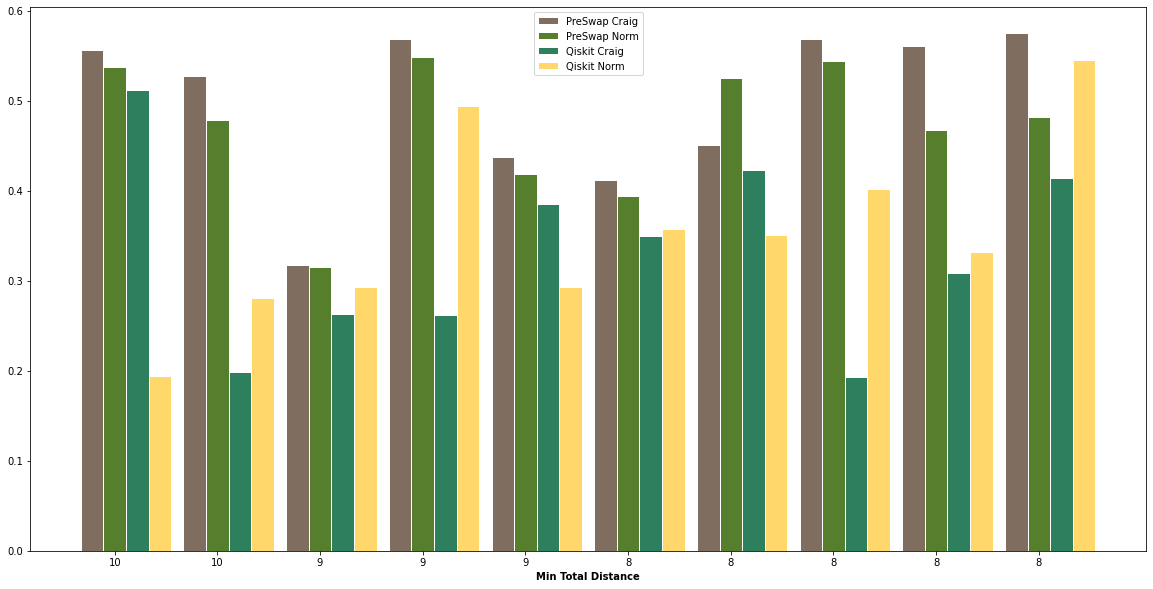

In [356]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
 
# set width of bar
barWidth = 0.22
 
# set height of bar
# bars1 = [12, 30, 1, 8, 22]
# bars2 = [28, 6, 16, 5, 10]
# bars3 = [29, 3, 24, 25, 17]
# bars1 = bars1_all[-10:]
# bars2 = bars2_all[-10:]
# bars3 = bars3_all[-10:]
# bars4 = bars4_all[-10:]
bars1 = bars1_all[:10:]
bars2 = bars2_all[:10]
bars3 = bars3_all[:10]
bars4 = bars4_all[:10]
xs = dists[:10]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='PreSwap Craig')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='PreSwap Norm')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='Qiskit Craig')
plt.bar(r4, bars4, color='#ffd76a', width=barWidth, edgecolor='white', label='Qiskit Norm')
 
# Add xticks on the middle of the group bars
plt.xlabel('Min Total Distance', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], xs) # , ['A', 'B', 'C', 'D', 'E'])
 
# Create legend & Show graphic
plt.legend()
plt.show()


In [127]:
c1 = create_mapped_circuit(backend, True, "craig", gen_random_init_mapping(20, seed=100))
c2 = create_mapped_circuit(backend, False, "craig", gen_random_init_mapping(20, seed=100))
c3 = create_mapped_circuit(backend, True, 'norm', gen_random_init_mapping(20, seed=100))
c4 = create_mapped_circuit(backend, False, 'norm', gen_random_init_mapping(20, seed=100))

In [128]:
c1.draw(fold=-1)

░          
  q46_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_1 -> 1 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_2 -> 2 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_3 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_4 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_5 -> 5 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_6 -> 6 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_7 -> 7 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_8 -> 8 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                           ░          
  q46_9 -> 9 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                  ┌───┐          ┌───┐            ┌───┐                                                                                                                    ░          
q46_10 -> 10 ─────┤ X ├───────■──┤ X ├─────■──────┤ X ├──■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                  └─┬─┘     ┌─┴─┐└─┬─┘     │      └─┬─┘  │                                                                                       

In [129]:
c2.draw(fold=-1)

░          
  q47_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_1 -> 1 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_2 -> 2 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_3 -> 3 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_4 -> 4 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_5 -> 5 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_6 -> 6 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_7 -> 7 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_8 -> 8 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                  ░          
  q47_9 -> 9 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                 ┌───┐          ┌───┐                                                                                                             ░          
q47_10 -> 10 ─────────────────■──┤ X ├──■────■──┤ X ├──■──────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
             ┌─────────────┐┌─┴─┐└─┬─┘┌─┴─┐  │  └─┬─┘  │                                                                                                          ░          
q47_11 -> 11 ┤ U2(pi/4,pi) ├┤ X ├──■──┤ X ├──┼────┼────┼────────────────────────────────────────────────────────────────────────────────────────────────────────

In [130]:
c3.draw(fold=-1)

░          
  q48_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_1 -> 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_2 -> 2 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_3 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_4 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_5 -> 5 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_6 -> 6 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_7 -> 7 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_8 -> 8 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                            ░          
  q48_9 -> 9 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                ┌───┐         ┌───┐     ┌───┐                                                                                                                               ░          
q48_10 -> 10 ───┤ X ├──────■──┤ X ├──■──┤ X ├──■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                └─┬─┘    ┌─┴─┐└─┬─┘  │  └─┬─┘  │                                                                            

In [131]:
c4.draw(fold=-1)

░          
  q49_0 -> 0 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_1 -> 1 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_2 -> 2 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_3 -> 3 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_4 -> 4 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_5 -> 5 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_6 -> 6 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_7 -> 7 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_8 -> 8 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
  q49_9 -> 9 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
                                                                                                                                                                                 ░          
q49_10 -> 10 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
             ┌─────